Krzysztof Ślot

Uczenie nienadzorowane: materiały wykładowe


# Algorytmy grupowania (klasteryzacji)

Jednym z podstawowywch zadań nienadzorowanej eksploracji danych jest grupowanie (klasteryzacja) - próba automatyzacji procesu odkrywania podobieństw i różnic między przedstawianymi algorytmowi próbkami w celu przypisywania ich do różnych zbiorów. Zdolność do grupowania bodźców to elementarna umiejętność organizmów żywych, niezbędna do budowy uogólnionego opisu otoczenia, zapełnionego obiektami należącymi do różnych kategorii.

Zadanie odkrywania kategorii, do których należą dostępne próbki i powiązane z tym zadanie przypisywania próbkom etykiet jest sztandarowym problemem uczenia nienadzorowanego, o licznych zastosowaniach praktycznych (badania rynkowe - identyfikacja preferencji i profilowanie, biologia - identyfikacja białek, genów, medycyna - identyfikacja reguł i związków przyczynowo-skutkowych itp.).

Problem grupowania ma jasną reprezentację formalną: dany zbiór próbek $\{ \mathbf{x} \}$ należy podzielić na podzbiory w taki sposób, by w obrębie każdego z nich próbki były 'podobne', a jednocześnie były one 'niepodobne' do próbek znajdujących się w innych podzbiorach. Kluczem do osiągnięcia celu jest określenie odpowiednich kryteriów oceny podobieństwa i odpowiednich metod generacji podzbiorów.


In [1]:
# import bibliotek
import numpy as np
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
import matplotlib.pyplot as plt

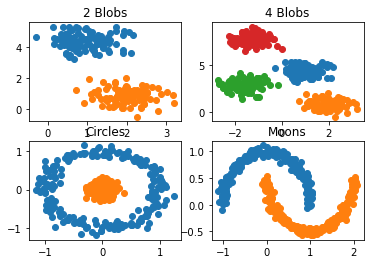

In [21]:
# Zbiory danych wykorzystywane w dokumencie
# argument metod rand_int - jeśli inny niż None zapewnia powtarzalność generacji
# noise: siła losowego odstępstwa od reguły generacji
# wynik metod: X - próbki, y - etykiety

# Izotropowe rozkłady Gaussa - blobs
K=2
XB2, yB2 = make_blobs(n_samples=100*K, n_features=2, centers=K, cluster_std=0.5, random_state=0)
K=4
XB_K, yB_K = make_blobs(n_samples=100*K, n_features=2, centers=K, cluster_std=0.5, random_state=0)
# Dwa koncentryczne okręgi
XC, yC = make_circles(n_samples=400, noise=0.1, factor=0.1)
# dwa wklęsłe 'półksiężyce
XM, yM = make_moons(n_samples=400, noise=0.05)
# Wizualizacja
fig, axs = plt.subplots(2, 2)
axs[0, 0].set_title('2 Blobs')
for i in range(2):
    axs[0,0].scatter(XB2[np.where(yB2==i),0], XB2[np.where(yB2==i),1])
axs[0, 1].set_title(str(K) + ' Blobs')
for i in range(K):
    axs[0,1].scatter(XB_K[np.where(yB_K==i),0], XB_K[np.where(yB_K==i),1])
axs[1, 0].set_title('Circles')
for i in range(K):
    axs[1,0].scatter(XC[np.where(yC==i),0], XC[np.where(yC==i),1])
axs[1, 1].set_title('Moons')
for i in range(K):
    axs[1,1].scatter(XM[np.where(yM==i),0], XM[np.where(yM==i),1])

## Klasteryzacja metodą k-średnich (k-Means clustering)

Najprostszym koncepcyjnie pomysłem na klasteryzację jest metoda k-średnich, w której dostępny zbiór próbek jest dzielony na rozłączne podzbiory (tzn. próbka należeć będzie tylko i wyłącznie do jednego z nich), przy czym podzbiory definiują reprezentatywne wektory - 'środki klas', a kryterium przypisania próbki do zbioru (klasy) to jej odległość do środka klasy.

Celem algorytmu jest zapewnienie 'najlepszego' możliwego podziału próbek między klasy (czyli wyboru dla zadanej liczby K położeń centroidów), gdzie 'najlepszy' podział to ten, który minimalizuje wartość funkcji kryterialnej:

\begin{equation}
\mathbf{M}^* = [\mathbf{m}_0^* ... \mathbf{m}^*_{K-1}] = \arg \min_\mathbf{M} \frac{1}{n} \sum_{i=0}^K n_i \sum_{j=0}^{n_i} || \mathbf{x}_{ij} - \mathbf{m}_i || \hspace{2cm} (1)
\end{equation}

Optymalne położenia środków klas (centroidów) zapewniają najmniejszy skumulowany błąd dopasowania próbek. 
Algorytm podziału zbioru w metodzie k-średnich to naprzemienne powtarzanie dwóch operacji: przypisywania próbek do klas i reestymacji parametrów klas (położeń środków klas). Można wykazać, że algorytm jest zbieżny, chociaż nie ma gwarancji, że będzie zbieżny do minimum globalnego.

Metoda jest koncepcyjnie niezwykle prosta, ma niestety też fundamentalne wady. Aby efekt klasteryzacji był sensowny, próbki w rzeczywistości powinny należeć do klas które zdecydowanie się od siebie różnią, a w obrębie klasy zróżnicowanie powinno mieć charakter niedużych modyfikacji 'ideału'. Wybór miary odległości stosowanej w klasteryzacji metodą k-średnich narzuca oczekiwaną geometrię rozkładu próbek, co ma zwykle mało wspólnego z rzeczywistością - np. przyjęcie normy Euklidesa implikuje oczekiwanie 'radialnej' struktury rozkładu próbek. Metoda k-średnich również całkowicie zawodzi, jeśli klastry się nakładają, co jest typowe w odniesieniu do rozkładów rzeczywistych kategorii. Kolejna słabość metody to konieczność zastosowania dodatkowych algorytmów pozwalających na identyfikację właściwej liczby klastrów (czyli - ile wynosi właściwa wartość parametru 'k'). W efekcie, grupowanie metodą k-średnich jest skuteczne tylko w odniesieniu do prostych problemów (lub w odniesieniu do odpowiednio przekształconych danych, które spełniają przdstawione wymagania).



In [9]:
# Funkcja pomocnicza dla k-Means: kryteium oceny poprawności klasteryzacji (równanie (1))
def obliczFunKryt(labels,X,AssumedK):
    d = 0
    # dla każdej klasy oblicz odstępstwo od centroidu
    for i in range(AssumedK):
        n_i = np.sum(labels==i) # liczba próbek klasy i
        var = np.std(X[labels==i,:])
        d += n_i*var
    return d/labels.shape[0]

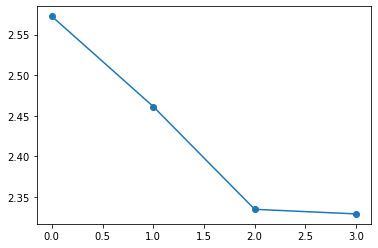

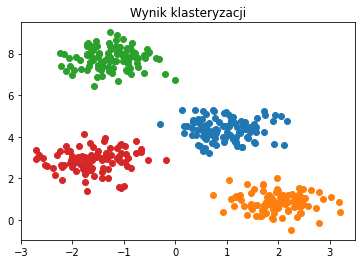

In [10]:
# Przykład - grupowanie metodą k-Means dla próbek pochodzących z izotropowych rozkładów Gaussa

X = XB_K
# procedura zakłada, że mamy>2 klastry ... (dla k=2 kryterium wyboru optymalnej liczby nie zadziała, bo kMeans wymaga >1 klastra)

# Algorytm grupowania: zakładamy sprawdzanie wielu hipotez odnośnie liczby klastrów (od 2 do max_clusters)
max_clusters = 5
Loss = np.zeros(max_clusters-1) # minimalna liczba klastrów to 2
# Pętla operacji: grupuj - rejestruj wartość funkcji kryterialnej (by wybrać optymalną liczbę klastrów)
for AssumedK in range(2,max_clusters+1):
    clusters = KMeans(n_clusters=AssumedK, random_state=None).fit(X)
    Loss[AssumedK-2] = obliczFunKryt(clusters.labels_,X,AssumedK)
# Przedstawienie wartości funkcji kryterialnej dla różnych hipotez co do liczby klastrów (wybór optimum - 'łokieć')
plt.figure()
plt.plot(range(max_clusters-1),Loss, marker='o')
OptK = np.argmin(Loss[1:]-Loss[:-1]) + 3 # w Loss pozycja '0' to 2 klastry
# wizualizacja wyników - próbki różnych klastrów oznaczane są różnymi kolorami
clusters = KMeans(n_clusters=OptK, random_state=None).fit(X)
plt.figure()
plt.title('Wynik klasteryzacji')
for i in range(AssumedK):
    plt.scatter(X[np.where(clusters.labels_==i),0], X[np.where(clusters.labels_==i),1])

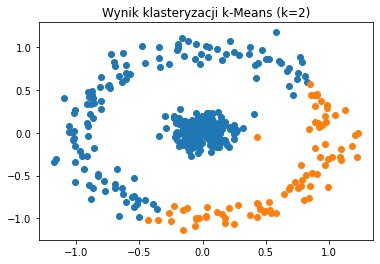

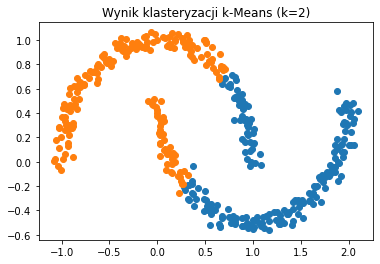

In [11]:
# --------------- trudniejsze rozkłady (nieseparowalne liniowo)
K=2 # zakładam, że znam optymalną liczbę klastrów, czyli n_clusters =2
X = XC # dane koncentryczne
# klasteryzacja - 
clusters = KMeans(n_clusters=K, random_state=None).fit(X)
plt.figure()
plt.title('Wynik klasteryzacji k-Means (k=' + str(K) + ')')
for i in range(K):
    plt.scatter(X[np.where(clusters.labels_==i),0], X[np.where(clusters.labels_==i),1])

X = XM # inny rozkład - wklęsłe 'półksiężyce'
clusters = KMeans(n_clusters=K, random_state=None).fit(XM)
plt.figure()
plt.title('Wynik klasteryzacji k-Means (k=' + str(K) + ')')
for i in range(K):
    plt.scatter(XM[np.where(clusters.labels_==i),0], XM[np.where(clusters.labels_==i),1])


## Klasyfikacja GMM i metoda EM klasteryzacji

Algorytm k-średnich grupowania może być traktowany, jako metoda odkrywania modelu klasy złożonej z wielu różnych skupień, przy bardzo restrykcyjnym założeniu, że każde z nich ma jednostkową macierz kowariancji. Takie założenie jest nierealne w odniesieniu do modelowania klas i obiektów rzeczywistych (cechy obiektów rzeczywistych są ze sobą skorelowane, więc nie można ich opisać za pomocą diagonalnej macierzy kowariancji). Dlatego też, naturalnym kierunkiem prac nad budowaniem lepszych modeli klas jest aproksymacja skupień za pomocą funkcji Gaussa o dowolnych strukturach macierzy kowariancji. 

Sposób modelowania klasy z użyciem wielu funkcji Gaussa o dowolnych parametrach, i wynikający z niej pomysł na klasyfikację danych z pomocą utworzonej reprezentacji, nazywa się algorytmem 'mieszaniny modeli Gaussowskich' (ang. Gaussian Mixture Model - GMM). GMM to bardzo realistyczny pomysł na reprezentację i analizę danych, oferujący możliwość budowy modeli klas o bardzo skomplikowanych rozkładach próbek. Metoda budowy modelu klasy to uogólnienie strategii przyjętej w metodzie k-średnich, nazywana algorytmem EM (ang. Expectation Maximization) - maksymalizacji wartości oczekiwanej. 

Celem uczenia modeli klas jest wyznaczenie zbiorów parametrów funkcji Gaussa (wektorów średnich i macierzy kowariancji), które najlepiej pasują do zbioru posiadanych przykładów, a drogą do uzyskania tego celu jest taki wybór ich wartości, które maksymalizują prawdopodobieństwo wystąpienia próbek. Dlatego też, metoda GMM jest metodą zaliczaną do probabilitstycznych strategii uczenia maszynowego.

Metoda EM, podobnie jak metoda k-średnich, to iteracyjne powtarzanie dwufazowej procedury, w której naprzemiennie uaktalniane są parametry statystyczne rozkładów (wektory średnie i macierze kowariancji) oraz dokonywane są oceny przynależności próbek do klastrów. W przeciwieństwie do metody k-średnich, każda próbka należy do każdego z klastrów, tyle że z prawdopodobieństwem wynikającym z jej położenia względem parametrów klastra (określanym przez odległość Mahalabobisa od tego klastra).  


Wynik algorytmu EM grupowania to model 'probabilistyczny'. Oznacza to, że daje on możliwość generacji nowych próbek, zgodnie z wyuczonym rozkładem prawdopodobieństwa. Takie modele nazywane są modelami generacyjnymi i pozwalają np. na augmentację zbiorów posiadanych przykładów, uzupełnianie brakujących elementów wektorów próbek ('imputacja' danych)




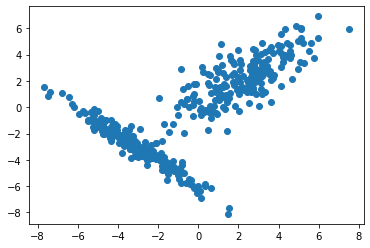

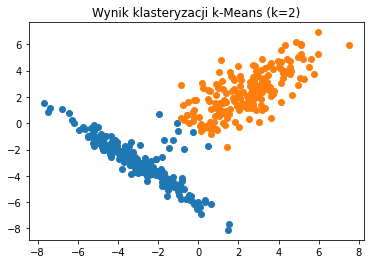

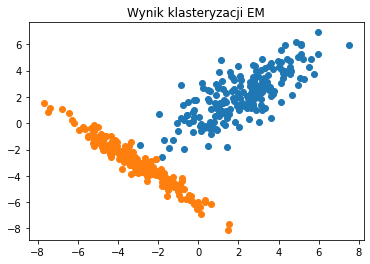

In [12]:
from sklearn.mixture import GaussianMixture

n=200
mu1 = np.array([2,2])
C1 = np.array([[3,2],[2,3]])
mu2 = np.array([-3,-3])
C2 = np.array([[3,-2.9],[-2.9,3]])
X = np.zeros((2,2*n))
X[0,:n], X[1,:n] = np.random.multivariate_normal(mu1, C1, n).T
X[0,n:], X[1,n:] = np.random.multivariate_normal(mu2, C2, n).T
plt.figure()
plt.scatter(X[0,:],X[1,:])

clusters = KMeans(n_clusters=2, random_state=None).fit(X.T)
plt.figure()
plt.title('Wynik klasteryzacji k-Means (k=2)')
for i in range(K):
    plt.scatter(X[0,np.where(clusters.labels_==i)], X[1,np.where(clusters.labels_==i)])


gm = GaussianMixture(n_components=2, random_state=0).fit(X.T)
labels = gm.predict(X.T)
nlabels = len(np.unique(labels))
plt.figure()
plt.title('Wynik klasteryzacji EM')
for i in range(nlabels):
    plt.scatter(X[0,np.where(labels==i)], X[1,np.where(labels==i)])

## Nieparametryczne algorytmy klasteryzacji

Jeżeli nie istnieją podstawy do przyjęcia założeń co do rodzaju rozkładów próbek, stosowanie metod parametrycznych (a więc takich, w których klastry są reprezentowane przez modele matematyczne wykorzystujące parametry, których określenie jest celem algorytmu), takich jak k-Means jest nieuzasadnione (wyjątkiem jest tu metoda GMM). 

Sposobem na poradzenie sobie w sytuacji braku modeli rozkładów jest stosowanie metod nieparametrycznych. Jedną z najogólniejszych taksonomii metod nieparametrycznych jest ich podział na metody grupowania hierarchicznego i spektralnego. Istotą metod hierarchicznych jest przypisywanie próbek do klastrów na podstawie oceny podobieństwa do innych próbek (a nie do parametrycznych modeli). Wybór miary podobieństwa jest zależny od przyjętej metody, podobnie jak wybór progów używanych w podejmowaniu decyzji. Istnieją dwie podstawowe strategie klasteryzacji hierarchicznej: aglomeracyjna i 'podziałowa' (ang. agglomerative, divisive). W pierwszym przypadku klastry tworzone są poprzez dodawanie do już istniejących zbiorów kolejnych elementów, o ile są one wystarczająco podobne do elementów tego zbioru. W drugim, punktem wyjścia jest pełny zbiór próbek, który jest rekurencyjnie dzielony na podzbiory, o ile w obrębie aktualnie rozważanego zbioru występuje nadmierne zróżnicowanie próbek.

### Algorytm DBSCAN

Niezwykle prostym i bardzo często stosowanym aglomeratywnym algorytmem klasteryzacji nieparametrycznej jest metoda DBSCAN. Klasteryzacja składa się z dwóch podstawowych faz, a podstawą oceny podobieństwa są odległości między wektorami reprezentującymi próbki. W pierwszej fazie identyfikowane są próbki 'wewnętrzne', które można uznać za elementy większych skupień próbek (tzw. core samples), ponieważ mają one w założonym otoczeniu odpowiednio dużą liczbę sąsiadów (zarówno promień sąsiedztwa jak i liczba precyzująca termin 'dużo' są parametrami metody). Druga faza to budowa klastrów z tych próbek wewnętrznych, które należą do otoczenia innych próbek wewnętrznych (przypisywanie im tej samej etykiety). Zamknięciem drugiej fazy jest dodanie do klastrów próbek, które nie są wewnętrzne, ale leżą w zadanej bliskości (należą do otoczeń) poetykietowanych wcześniej próbek wewnętrznych.

Materiały dodatkowe dotyczące DBSCAN https://www.youtube.com/watch?v=RDZUdRSDOok


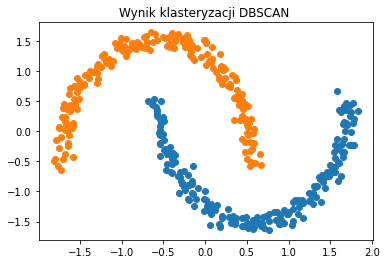

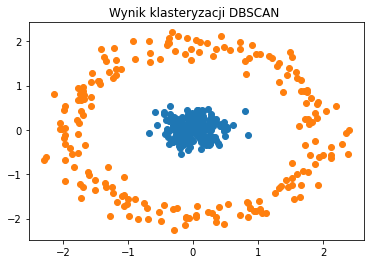

In [16]:
# Przykład: klasteryzacja zbiorów nieseparowalnych liniowo metodą DBSCAN

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(XM)
dbs_clusters = DBSCAN(eps=0.26, min_samples=4).fit(X)

n_clusters_ = len(set(dbs_clusters.labels_)) - (1 if -1 in dbs_clusters.labels_ else 0)
plt.figure()
plt.title('Wynik klasteryzacji DBSCAN ')
for i in range(n_clusters_):
    plt.scatter(X[np.where(dbs_clusters.labels_==i),0], X[np.where(dbs_clusters.labels_==i),1])

    
X = StandardScaler().fit_transform(XC)
dbs_clusters = DBSCAN(eps=0.4, min_samples=4).fit(X)

n_clusters_ = len(set(dbs_clusters.labels_)) - (1 if -1 in dbs_clusters.labels_ else 0)
plt.figure()
plt.title('Wynik klasteryzacji DBSCAN ')
for i in range(n_clusters_):
    plt.scatter(X[np.where(dbs_clusters.labels_==i),0], X[np.where(dbs_clusters.labels_==i),1])
      

### Metody nieparametryczne - Affinity Propagation

Metoda 'propagacji podobieństwa' to metoda, która jest, podobnie jak inne metody aglomeracyjne, jest oparta na koncepcji przypisywania tych samych etykiet próbkom, położonym w swoim sąsiedztwie. To, co dla tej metody jest unikatowe, to forma  generowanego przez nią wyniku: efektem grupowania jest, oprócz przypisania próbkom etykiet, również wskazanie próbki, która jest uznawana za 'prototyp' danego skupienia, czyli próbki najbardziej reprezentatywnej dla klastra. 

Możliwość wskazania próbki reprezentatywnej dla klastra ma istotne znaczenie praktyczne - np. w badaniach genomicznych taka próbka to gen z minimalną liczbą mutacji, 


Dodatkowe materiały: Brendan J. Frey and Delbert Dueck, “Clustering by Passing Messages Between Data Points”, Science Feb. 2007

Reprezentant klastra nr 1 to próbka nr: [230]


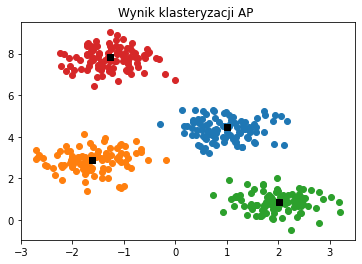

In [17]:
from sklearn.cluster import AffinityPropagation
X = XB_K
AP = AffinityPropagation(preference=-35, random_state=0).fit(X)
labels = AP.labels_
nlabels = len(np.unique(labels))
plt.figure()
plt.title('Wynik klasteryzacji AP ')
for i in range(nlabels):
    plt.scatter(X[np.where(labels==i),0], X[np.where(labels==i),1])

plt.scatter(AP.cluster_centers_[:,0],AP.cluster_centers_[:,1], color='k', marker='s')
# znalezienie reprezentanta klastra nr 1
y = AP.cluster_centers_
res_x = np.where(X[:,0]==y[0,0])
res_y = np.where(X[:,1]==y[0,1])
if res_x[0]==res_y[0]:
    print('Reprezentant klastra nr 1 to próbka nr: ' + str(res_x[0]))


## Klasteryzacja Spektralna (Spectral Clustering)

Klasteryzacja spektralna jest uznawana obecnie za metodę 'state-of-the-art', ponieważ z jednej strony - posiada solidne fundamenty matematyczne, a z drugiej - daje doskonałe efekty, pasuje do rozwiązywania szeregu niezwykle istotnych problemów (grafy) i jest bardzo efektywna obliczeniowo.


### Grafy

Problemy uczenia maszynowego mogą wymagać utworzenia grafowej reprezentacji danych. odzwierciedlającej wiedzę o  próbkach i określonych na nich funkcjach oraz o relacjach występujących między próbkami. Przykładowo, predykcja siły i kierunku wiatru w danej lokalizacji (funkcja położenia), może być dokonywana na podstawie dostępnych informacji uzyskiwanych z rozmieszczonych w sąsiedztwie stacji pomiarowych. Wzajemne relacje między położeniami stacji i położeniem punktu, dla którego dokonujemy predykcji, można przedstawić w formie grafu, którego węzłami są położenia. Sensowną strukturą grafu jest zapewnienie połączeń jedynie między sąsiednimi węzłami (wpływ odległych węzłów będzie zawsze uwzględniany przez informacje uzyskiwane z węzłów bliższych). Podobnie, relacje między użytkownikami sieci społecznościowych mogą być dogodnie reprezentowane za pomocą grafów, posiadających lokalną strukturę. Grafy są naturalnym sposobem modelowania rozprzestrzeniania się chorób czy relacji gospodarczych. Co więcej, grafy można budować dla praktycznie dowolnego zadania, w którym mamy do czynienia z danymi (próbkami), dla których możliwe jest określanie podobieństwa, stanowiącego podstawę dla określania relacji między węzłami (próbkami).

Tworzenie grafu jako reprezentacji danego problemu rozpoczyna się od utworzenia połączeń między posiadanymi próbkami, przy czym sensowna podstawa konstukcji to wiązanie ze sobą gałęziami próbek podobnych. Połączenia - krawędzie grafu, mogą mieć wagi, oceniające stopień podowbieństwa. Istnieją dwie podstawowe metody określania połączeń między węzłami grafu: w pierwszej, kryterium to dołączanie do każdego węzła grafu jego k-najbliższych sąsiadów, drugie, to dołączanie wszystkich sąsiadów, znajdujących się w odległości mniejszej od zadanego progu.

Matematyczną reprezentacją grafu są macierze, zawierające pełną informację o połączeniach istniejących między węzłami, takie jak macierz incydencji (incidence matrix), macierz sąsiedztwa (adjacency matrix), macierz podobieństw (affinity matrix). 

Podstawowym sposobem opisu grafu dla uzyskania klasteryzacji jest macierz Lapace'a grafu (Graph Laplacian), równa różnicy macierzy 'rzędu' ($\mathbf{D}$ - macierz diagonalna o wartościach równych sumie elementów wierszy macierzy podobieństw) i macierzy podobieństw ($\mathbf{W}$): 

\begin{equation}
\mathbf{L} = \mathbf{D} - \mathbf{W} =  \left[ 
\begin{array}{ccc}
d_{11} & 0 & \cdots \\
0 & \vdots & \\
\cdots & 0 & d_{nn}
\end{array} \right] - 
\left[ 
\begin{array}{ccc}
0 & w_{12} & \cdots \\
w_{21} & \cdots &  \\
\cdots & \cdots & 0
\end{array} \right]
\end{equation}
gdzie $d_{ii} = \sum_j w_{ij}$.

Jeżeli na wierzchołkach grafu opiszemy funkcję, macierz Laplace'a mierzy lokalne 'niepodobieństwo', jakie występuje między wartościami tej funkcji między węzłem a jego sąsiadami. Na przykład, jeżeli węzły grafu odpowiadają pikselom obrazu (funkcja zdefiniowana dla piksela to np. jego jasność) to Laplacian grafu będzie informował o odstępstwach od jednorodności jasności w rozważanym sąsiedztwie (dla obszarów o stałej jasności jego wartości będą równe zeru).


### Kryterium separacji grafu

Podział próbek na grupy to w przypadku grafu - podział grafu, który powinien być dokonany zgodnie z kryterium odpowiadającym istocie klasteryzacji, czyli zapewniającym wydzielenie grup punktów (węzłów) podobnych w obrębie grupy i niepodobnych między grupami.
Zakładając, że krawędzi łączącej dwa wierzchołki: $v_i$ oraz $v_j$ przypisywana jest miara ich podobieństwa (waga) $w_{ij}$ oraz, że każdemu wierzchołkowi grafu przypisujemy etykietę $f$, gdzie dla problemu 2-klasowego będzie to np. 1 lub -1 (tzn. $f(v_i), f(v_j) = -1 \; lub \; 1$), możliwa funkcja kryterialna opisująca najlepszy możliwy podział grafu na podzbiory $\mathcal{A}$ - $\bar{\mathcal{A}}$ to podział minimalizujący wyrażenie:

\begin{equation}
J'(f_1, f_2 ... f_n) = \sum_{i=1}^n \sum_{j=1}^n w_{ij} \left( f(v_i) - f(v_j) \right)^2 \rightarrow \min
\end{equation}

gdzie $n$ to liczba próbek (wierzchołków). Sens kryterium to znalezienie takiego podziału, czyli podzbioru krawędzi $w_{ij}$, których sumaryczna wartość będzie najmniejszą z możliwych, a więc podziału, w którym grupy próbek o dużym podobieństwie będą miały takie same etykiety (wartości funkcji $f(v_i)=f(v_j)$). 

Ponieważ sama minimalizacja przedstawionego wyrażenia dawałaby w efekcie najprawdopodobniej 'odcięcie' pojedynczego węzła (któremu przypisano by etkietę np. '-1') od wszystkich pozostałych (z etykietami np.'1') z najmniejszą wartością skumulowanych wag łączących ten węzeł z pozostałymi, ograniczniem jakie musi zostać dodane do funkcji kryterialnej jest wymaganie, by tworzone podzbiory miały podobne liczby wierzchołków (elementów), a więc funkcja kryterialna przyjmuje postać:

\begin{equation}
J(f_1, f_2 ... f_n) = \sum_{i=1}^n \sum_{j=1}^n w_{ij} \left( f(v_i) - f(v_j) \right)^2, \hspace{0.2cm} |\mathcal{A}| \approx |\bar{\mathcal{A}}| \hspace{0.2cm} \rightarrow \min
\end{equation}

gdzie symbol |.| oznacza liczebność zbioru.


### Laplasjan grafu a funkcja kryterialna

Rozważmy wyrażenie:

\begin{equation}
\mathbf{f}^T \mathbf{L} \mathbf{f} = \sum_i f(v_i)^2 d_{ii} - \sum_{i=1}^n \sum_{j=1}^n f(v_i) w_{ij} f(v_j) = \sum_i f(v_i)^2 \sum_j w_{ij} - \sum_{i=1}^n \sum_{j=1}^n f(v_i) w_{ij} f(v_j)
\end{equation}

Proste przekształcenie: wyłączenie 1/2 i obserwacja, że $2\sum_i \alpha_i = \sum_i alpha_i + \sum_j alpha_j$ prowadzi do wyrażenia:

\begin{equation}
\frac{1}{2} (\sum_i \sum_j w_{ij} f(v_i)^2 - 2\sum_{i=1}^n \sum_{j=1}^n w_{ij} f(v_i) f(v_j) + \sum_j \sum_j w_{ij} f(v_j)^2,
\end{equation}

które jest identyczne z funkcją kryterialną J'. 

Wniosek 1:
Podstawą dla określenia funkcji kryterialnej pozwalającej na poszukiwanie najlepszego możliwego podziału grafu (tzn. minimalizującego globalne podobieństwo między tworzonymi podzbiorami) na dwie części jest Laplasjan grafu.


### Równanie spektralne dla Laplasjanu

Wynikiem obliczenia funkcji kryterialnej:
\begin{equation}
J'(\mathbf{f}) = \mathbf{f}^T \mathbf{L} \mathbf{f}
\end{equation}
dla danego kandydata na wektor etykiet $\mathbf{f}$ jest liczba. Oznaczając ten wynik przez $\lambda$, można zapisać, że:

\begin{equation}
\mathbf{f}^T \mathbf{L} \mathbf{f} = \lambda \rightarrow \mathbf{L} \mathbf{f} = \lambda \mathbf{f}
\end{equation}

Równanie 'macierz x wektor = liczba x wektor' to równanie spektralne macierzy, stanowiące podstawę do obliczenia jej wartości własnych i wektorów własnych. Ponieważ Laplasjan grafu to tzw. macierz PSD (dodatnio pół-określona), wartości własne są nieujemnymi liczbami rzeczywistymi. Co więcej, kolejne wartości własne to kolejne możliwe wartości wyrażenia J'. Jeśli zostaną one uporządkowane rosnąco, to obiektem zainteresowania dla rozważanego problemu klasteryzacji stają się wektory własne, odpowiadające początkowym wartościom własnym.

Rozważmy jaka jest najmniejsza możliwa wartość własna i jakiemu przyporządkowaniu etykiet odpowiada ta wartość. Z uwagi na strukturę Laplasjanu grafu, gdzie w każdym wierszu suma elementów wynosi zero, łatwo zauważyć, że dowolny wektor o stałych wartościach ($\mathbf{f^1} = [c, c, c, ...]$, gdzie $c \in \mathcal{R}$) prowadzi do równania:

\begin{equation}
\mathbf{L} \mathbf{f} = \mathbf{0}
\end{equation}

Oznacza to, że minimalna wartość własna dla rozważanego równania to zawsze $\lambda^1=0$. Nie jest to jednak poszukiwane rozwiązanie, bo wszystkie próbki (wierzchołki) mają taką samą etykietę ($c$), a więc znalezione rozwiązanie nie dotyczy podziału grafu. 

W efekcie, poszukiwanym rozwiązaniem jest wektor etykiet, który odpowiada drugiej najmniejszej wartości własnej.

### Rozwiązanie problemu klasteryzacji spektralnej

Jak wcześniej stwierdzono, wektorem etykiet minimalizującym funkcję kryterialną $J'(\mathbf{f})$ jest wektor własny równania spektralnego Laplasjanu grafu, odpowiadający drugiej najmniejszej wartości własnej. Jednak, jak wcześniej wspomniano, celem klasteryzacji spektralnej jest znalezienie wektora minimalizującego funkcję $J(.)$, w której dodatkowo pojawia się warunek podobnej liczności wierzchołków należących do obydwu klastrów. Ograniczenie to można wyrazić na wiele sposóbów, ale najprostszy to oczekiwanie, by:

\begin{equation}
\sum_{i=1}^n f_i = 0
\end{equation}

czyli, by w poszukiwanym wektorze było tyle samo komponentów (etykiet) dodatnich co ujemnych (jeśli etykiety będą liczbami binarnymi +1/-1). Jak łatwo zauważyć, taki warunek jest równoważny oczekiwaniu, by poszukiwany wektor był ortogonalny do wektora złożonego z samych wartości stałych. Ponieważ pierwszy wektor własny dla równania spektralnego macierzy Laplace'a grafu jest właśnie taki, z właściwości ortogonalności wektorów własnych macierzu PSD wynika, że znalezione poprzednio rozwiązanie - drugi wektor własny, jest jednocześnie rozwiązaniem kryterium $J(.)$, a więc stanowi wynik klasteryzacji spektralnej dla problemu dwóch skupień.

Wniosek:

Metoda spektralna klasteryzacji ma twarde podstawy matematyczne. Rozwiązuje problem, który jest NP-zupełny w sposób relatywnie efektywny obliczeniowo. Dla pełnych macierzy Laplace'a jej złożoność obliczeniowa jest rzędu $O(n^3)$, ale zwykle macierze te są rzadkie i rozwiązanie jest znacznie szybsze (możliwe jest efektywne obliczanie rozwiązania dla grafów zawierających dziesiątki tysięcy w).


In [18]:
# Funkcja pomocnicza wyznaczająca macierz Laplace's dla zbioru próbek X
def wyznaczLaplacjan(X):
    # obliczenie macierzy połączeń (dla próbki 'i' najbliżsi sąsiedzi to 'j')
    G = kneighbors_graph(X, n_neighbors=5, mode='distance')
    G = G.toarray()
    # macierz sąsiedztwa (adjacency matrix)
    AdjM = 0.5*(G + G.T) 
    # obliczenie degree-matrix
    D = np.diag(np.sum(AdjM, axis=1))
    # Obliczennie macierzy Laplace'a
    L = D - AdjM
    return L

Komponent nr 1; wartość: 1.0419657651374679e-16


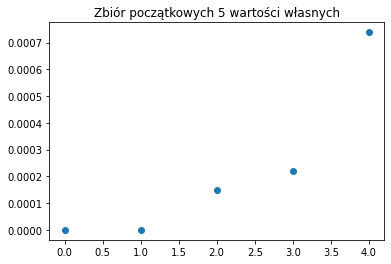

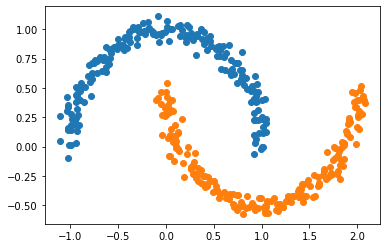

In [22]:
# %%  -------------------- Unnormalized Spectral Clustering
##############################################################################
from sklearn.neighbors import kneighbors_graph

'''
Algorytm: 
    1. Utworzenie grafu k-NN
    2. Obliczenie Laplasjanu dla grafu
    3. Identyfikacja drugiej wartości własnej i wektora własnego
    4. Etykietowanie próbek
'''
X = XM
L = wyznaczLaplacjan(X)

# Dekompozycja L
EVals, EVecs = np.linalg.eigh(L)
# posortowanie wyników
idx = np.argsort(EVals)
EVals = EVals[idx]
EVecs = EVecs[:,idx]
# wizualizacja wartości własnych
n_EVals = 5 # analiza wyniku dekompozycji - liczba wyświetlanych wartości własnych
plt.figure()
plt.scatter(range(n_EVals),EVals[:n_EVals])
plt.title('Zbiór początkowych ' + str(n_EVals) + ' wartości własnych')

# wybór drugiej wartości własnej i odpowiadającego jej wektora
nr=1
print('Komponent nr ' + str(nr) + '; wartość: ' + str(EVals[nr]))

# klasteryzacja wg wartości odpowiadającego wektora własnego
clusters = KMeans(n_clusters=2, random_state=None).fit(EVecs[:,nr].reshape(-1,1))
#Labels = EVecs[:,nr]>0
plt.figure()
plt.scatter(X[np.argwhere(clusters.labels_==0),0], X[np.argwhere(clusters.labels_==0),1])
plt.scatter(X[np.argwhere(clusters.labels_==1),0], X[np.argwhere(clusters.labels_==1),1])


### Klasteryzacja spektralna dla wielu klastrów

Jeżeli próbki zawierają więcej skupień, ich liczbę można zidentyfikować analizując rozkład wartości własnych laplasjanu grafu. Określone wcześniej kryterium wskazuje, poprzez wartości własne, skumulowaną wartość połączeń między grupami. Wektor własny odpowiadający każdej kolejnej niewielkiej wartości własnej (sygnalizującej 'dobry' podział) zawiera wartości (etykiety) próbek należących do dwóch grup. 

Jeśli w zbiorze próbek istnieją np. 3 skupienia, należy spodziewać się występowania dwóch większych od zera, bardzo małych wartości własnych. Kolejne elementy dwóch odpowiadających wektorów własnych stanowią pary binarnych etykiet, przypisanych każdej próbce. Aby przypisać te próbki do klastrów, należy dokonać grupowania próbek w dziedzinie otrzymanych dwuelementowych etykiet.


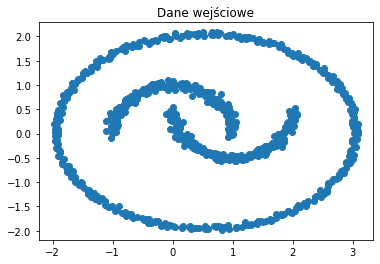

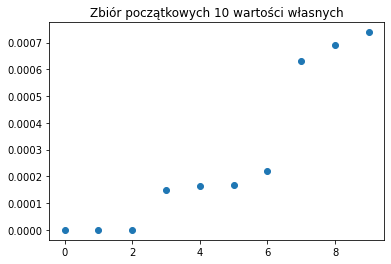

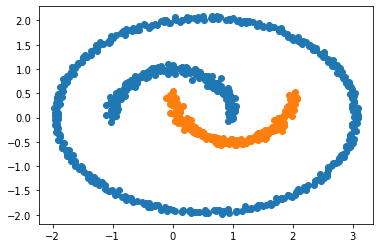

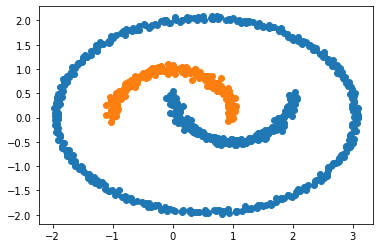

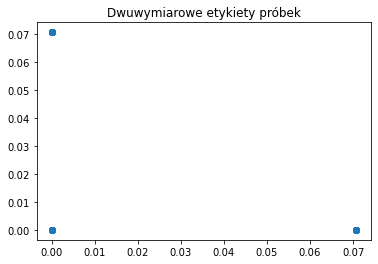

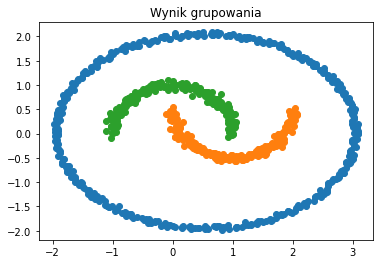

In [24]:
# Zbiór danych zawiera trzy liniowo nieseparowalne grupy próbek
nRing = 400
x = 2.5*np.cos(2*np.pi*np.arange(nRing)/nRing)+0.5 
y = 2*np.sin(2*np.pi*np.arange(nRing)/nRing)
XRing = np.stack((x,y))+ 0.1*np.random.rand(2,nRing)
X_Multiple = np.concatenate((XM, XRing.T))

plt.figure()
plt.scatter(X_Multiple[:,0], X_Multiple[:,1])
plt.title('Dane wejściowe')

X = X_Multiple
L = wyznaczLaplacjan(X)
# analiza spektralna Laplasjanu
EVals, EVecs = np.linalg.eigh(L)
# posortowanie wyników
idx = np.argsort(EVals)
EVals = EVals[idx]
EVecs = EVecs[:,idx]

# wynik dekompozycji - wizualizacja wartości własnych
n_EVals = 10 # liczba wyświetlanych wartości własnych
plt.figure()
plt.scatter(range(n_EVals),EVals[:n_EVals])
plt.title('Zbiór początkowych ' + str(n_EVals) + ' wartości własnych')

# Etykiety próbek przypisane przez wektor własny nr 1
nr=1
clusters = KMeans(n_clusters=2, random_state=None).fit(EVecs[:,nr].reshape(-1,1))
plt.figure()
plt.scatter(X[np.argwhere(clusters.labels_==0),0], X[np.argwhere(clusters.labels_==0),1])
plt.scatter(X[np.argwhere(clusters.labels_==1),0], X[np.argwhere(clusters.labels_==1),1])

# Etykiety próbek przypisane przez wektor własny nr 2
nr=2
clusters = KMeans(n_clusters=2, random_state=None).fit(EVecs[:,nr].reshape(-1,1))
plt.figure()
plt.scatter(X[np.argwhere(clusters.labels_==0),0], X[np.argwhere(clusters.labels_==0),1])
plt.scatter(X[np.argwhere(clusters.labels_==1),0], X[np.argwhere(clusters.labels_==1),1])

# Etykiety próbek wynikające z dwóch pierwszych wektorów własnych
plt.figure()
plt.title('Dwuwymiarowe etykiety próbek')
plt.scatter(EVecs[:,1], EVecs[:,2])

# Wynik klasteryzacji (zakładam, że znana jest liczba klastrów)
n_clusters = 3
clusters = KMeans(n_clusters=n_clusters, random_state=None).fit(EVecs[:,1:2])
plt.figure()
plt.title('Wynik grupowania')
for i in range(n_clusters):
    plt.scatter(X[np.argwhere(clusters.labels_==i),0], X[np.argwhere(clusters.labels_==i),1])
